In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import datetime

In [2]:
path_str = []
for path, sub_dirs, files in os.walk('msc-project-osa-data\data'):
    for file in files:
        doc = os.path.join(path, file).replace('\\', '/')
        path_str.append(doc)

In [3]:
id_list = []
for doc in path_str:
    split_doc = doc.split("/")
    single_id = int(split_doc[2])
    id_list.append(single_id)
id_list= list(set(id_list))

In [4]:
gender = pd.read_csv('osa_patients.csv')
id_to_gender = dict(zip(gender.Patient, gender.Gender))
del id_to_gender[8]
id_to_gender = dict( (k,v.lower()) for k,v in id_to_gender.items())

id_to_age = dict(zip(gender.Patient, gender.Age))
del id_to_age[8]

id_to_bmi = dict(zip(gender.Patient, gender.BMI))
del id_to_bmi[8]

In [5]:
def taks1_data(patient_id, event):
    relevant_doc_list = [doc for doc in path_str if event in doc and patient_id in doc]
    
    all_data_gender = []
    index_list = []    
    
    for doc in relevant_doc_list:
        data = pd.read_csv(doc, sep = ';', names=['time','duration','type'], engine='python')
        data = data[4:].reset_index(drop=True)
        if len(data.iloc[0,0]) < 26:
                data[['start','stop']] = data['time'].str.split('-',expand=True)
        else:
            data[['time','start']] = data['time'].str.split(' ',expand=True)
            data[['start','stop']] = data['start'].str.split('-',expand=True)
            
        data['start'] = pd.to_datetime(data['start'])
        data['stop'] = pd.to_datetime(data['stop'])
        
        data = data[data['duration'] >= 10]
        
        night_hours =  abs((data.iloc[0]['start'] - data.iloc[-1]['stop']) / pd.Timedelta(hours=1))
        event_list = ['Obstructive Apnea', 'Central Apnea', 'Hypopnea']
        
        df_index = pd.DataFrame(data.type.value_counts()).rename(columns = {'type':'apnea index','index' :'type'}) / night_hours
        df_index['ID'] = int(patient_id)
        df_index['gender'] = id_to_gender[int(patient_id)]
        df_index = df_index[df_index.index.isin(event_list)]

        data = data.drop('time', 1)
        
        all_data_gender.append(data)
        index_list.append(df_index)
        
    gender_correlation = pd.concat(all_data_gender, ignore_index=True)
    index_correlation = pd.concat(index_list, axis=0)
    
    return gender_correlation, index_correlation

In [6]:
def get_data(event):
    all_data_duration = []
    all_data_index = []
    for patient in id_to_gender.keys():
        p_id =  "{0:03}".format(patient)
        data, index = taks1_data(p_id, event)
        
        data['gender'] = id_to_gender[patient]
        data['ID'] = patient
        data['age'] = data['ID'].map(id_to_age)
        data['BMI'] = data['ID'].map(id_to_bmi)
        data['age rank'] = pd.cut(data.age, bins=[24,34,44,54,64,71], labels=['24-34', '35-44', '45-54', '55-64',' ≥65'])
        data['BMI rank'] = pd.cut(data.BMI, bins=[18,25,30,35,49], labels=['18-25', '25-30', '30-35','35-49'])
        
        index['age'] = index['ID'].map(id_to_age)
        index['BMI'] = index['ID'].map(id_to_bmi)
        index['age rank'] = pd.cut(index.age, bins=[24,34,44,54,64,71], labels=['24-34', '35-44', '45-54', '55-64',' ≥65'])
        index['BMI rank'] = pd.cut(index.BMI, bins=[18,25,30,35,49], labels=['18-25', '25-30', '30-35','35-49'])
        
        all_data_duration.append(data)
        all_data_index.append(index)
        
    final_data_duration = pd.concat(all_data_duration, ignore_index=True)
    final_data_index = pd.concat(all_data_index, axis=0)
    
    return final_data_duration, final_data_index

In [7]:
def get_stat_index(data):
    data['type'] = data.index
    sta_count = pd.DataFrame(data.type.value_counts()).rename(columns = {'type':'count','apnea index' :'type'})
    sta_mean = data.groupby('type')['apnea index'].mean().rename('apnea index mean')
    sta_std = data.groupby('type')['apnea index'].std().rename('apnea index std')
    summary = pd.concat([sta_count,sta_mean, sta_std], axis=1)
    
    z = 1.960 #for 95% confidence interval
    ci =  z * summary['apnea index std'] / summary['count'] ** 0.5
    
    summary["ci"] = ci
    summary["low apnea index"] = summary['apnea index mean'] - summary["ci"]
    summary["high apnea index"] = summary['apnea index mean'] + summary["ci"]
    
    return summary

In [8]:
def get_stat_duration(data):
    sta_count = pd.DataFrame(data.type.value_counts()).rename(columns = {'type':'count','index' :'type'})
    sta_mean = data.groupby('type')['duration'].mean().rename('duration mean')
    sta_std = data.groupby('type')['duration'].std().rename('duration std')
    summary = pd.concat([sta_count,sta_mean, sta_std], axis=1)
    
    z = 1.960 #for 95% confidence interval
    ci =  z * summary['duration std'] / summary['count'] ** 0.5
    
    summary["ci"] = ci
    summary["low duration"] = summary['duration mean'] - summary["ci"]
    summary["high duration"] = summary['duration mean'] + summary["ci"]
    
    return summary

In [9]:
def get_stat_bmi_index(data):
    sta_count = pd.DataFrame(data['BMI rank'].value_counts()).rename(columns = {'BMI rank':'count','apnea index' :'BMI rank'})
    sta_mean = data.groupby('BMI rank')['apnea index'].mean().rename('apnea index mean')
    sta_std = data.groupby('BMI rank')['apnea index'].std().rename('apnea index std')
    summary = pd.concat([sta_count,sta_mean, sta_std], axis=1)
    
    z = 1.960 #for 95% confidence interval
    ci =  z * summary['apnea index std'] / summary['count'] ** 0.5
    
    summary["ci"] = ci
    summary["low apnea index"] = summary['apnea index mean'] - summary["ci"]
    summary["high apnea index"] = summary['apnea index mean'] + summary["ci"]
    
    return summary

In [10]:
def get_stat_bmi_duration(data):
    sta_count = pd.DataFrame(data['BMI rank'].value_counts()).rename(columns = {'BMI rank':'count','index' :'BMI rank'})
    sta_mean = data.groupby('BMI rank')['duration'].mean().rename('duration mean')
    sta_std = data.groupby('BMI rank')['duration'].std().rename('duration std')
    summary = pd.concat([sta_count,sta_mean, sta_std], axis=1)  
    
    z = 1.960 #for 95% confidence interval
    ci =  z * summary['duration std'] / summary['count'] ** 0.5
    
    summary["ci"] = ci
    summary["low duration"] = summary['duration mean'] - summary["ci"]
    summary["high duration"] = summary['duration mean'] + summary["ci"]
    
    return summary

In [11]:
def get_stat_age_index(data):
    sta_count = pd.DataFrame(data['age rank'].value_counts()).rename(columns = {'age rank':'count','apnea index' :'age rank'})
    sta_mean = data.groupby('age rank')['apnea index'].mean().rename('apnea index mean')
    sta_std = data.groupby('age rank')['apnea index'].std().rename('apnea index std')
    summary = pd.concat([sta_count,sta_mean, sta_std], axis=1)
    
    z = 1.960 #for 95% confidence interval
    ci =  z * summary['apnea index std'] / summary['count'] ** 0.5
    
    summary["ci"] = ci
    summary["low apnea index"] = summary['apnea index mean'] - summary["ci"]
    summary["high apnea index"] = summary['apnea index mean'] + summary["ci"]
    
    return summary

In [12]:
def get_stat_age_duration(data):
    sta_count = pd.DataFrame(data['age rank'].value_counts()).rename(columns = {'age rank':'count','index' :'age rank'})
    sta_mean = data.groupby('age rank')['duration'].mean().rename('duration mean')
    sta_std = data.groupby('age rank')['duration'].std().rename('duration std')
    summary = pd.concat([sta_count,sta_mean, sta_std], axis=1)  
    
    z = 1.960 #for 95% confidence interval
    ci =  z * summary['duration std'] / summary['count'] ** 0.5
    
    summary["ci"] = ci
    summary["low duration"] = summary['duration mean'] - summary["ci"]
    summary["high duration"] = summary['duration mean'] + summary["ci"]
    
    return summary

In [13]:
flow_data_duration, flow_data_apnea_index = get_data('Flow')

<ipython-input-5-128864b69676>:29: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = data.drop('time', 1)


In [14]:
flow_data_duration

,duration,type,start,stop,gender,ID,age,BMI,age rank,BMI rank
0,102.0,Obstructive Apnea,2022-05-17 23:03:52.246,2022-05-17 23:05:34.246,male,1,61,25.396568,55-64,25-30
1,10.0,Obstructive Apnea,2022-05-17 23:06:06.246,2022-05-17 23:06:15.996,male,1,61,25.396568,55-64,25-30
2,79.0,Hypopnea,2022-05-17 23:25:55.246,2022-05-17 23:27:14.621,male,1,61,25.396568,55-64,25-30
3,14.0,Obstructive Apnea,2022-05-17 23:45:49.246,2022-05-17 23:46:02.996,male,1,61,25.396568,55-64,25-30
4,22.0,Obstructive Apnea,2022-05-17 23:53:20.246,2022-05-17 23:53:42.121,male,1,61,25.396568,55-64,25-30
...,...,...,...,...,...,...,...,...,...,...
79375,15.0,Obstructive Apnea,2022-05-17 03:21:42.414,2022-05-17 03:21:57.694,female,202,55,40.723773,55-64,35-49
79376,23.0,Obstructive Apnea,2022-05-17 03:22:09.246,2022-05-17 03:22:32.621,female,202,55,40.723773,55-64,35-49
79377,20.0,Obstructive Apnea,2022-05-17 03:22:43.246,2022-05-17 03:23:03.121,female,202,55,40.723773,55-64,35-49
79378,21.0,Obstructive Apnea,2022-05-17 03:23:12.246,2022-05-17 03:23:33.246,female,202,55,40.723773,55-64,35-49


In [15]:
sta_count = pd.DataFrame(flow_data_duration['age rank'].value_counts()).rename(columns = {'type':'count','apnea index' :'type'})

In [16]:
flow_data_duration

,duration,type,start,stop,gender,ID,age,BMI,age rank,BMI rank
0,102.0,Obstructive Apnea,2022-05-17 23:03:52.246,2022-05-17 23:05:34.246,male,1,61,25.396568,55-64,25-30
1,10.0,Obstructive Apnea,2022-05-17 23:06:06.246,2022-05-17 23:06:15.996,male,1,61,25.396568,55-64,25-30
2,79.0,Hypopnea,2022-05-17 23:25:55.246,2022-05-17 23:27:14.621,male,1,61,25.396568,55-64,25-30
3,14.0,Obstructive Apnea,2022-05-17 23:45:49.246,2022-05-17 23:46:02.996,male,1,61,25.396568,55-64,25-30
4,22.0,Obstructive Apnea,2022-05-17 23:53:20.246,2022-05-17 23:53:42.121,male,1,61,25.396568,55-64,25-30
...,...,...,...,...,...,...,...,...,...,...
79375,15.0,Obstructive Apnea,2022-05-17 03:21:42.414,2022-05-17 03:21:57.694,female,202,55,40.723773,55-64,35-49
79376,23.0,Obstructive Apnea,2022-05-17 03:22:09.246,2022-05-17 03:22:32.621,female,202,55,40.723773,55-64,35-49
79377,20.0,Obstructive Apnea,2022-05-17 03:22:43.246,2022-05-17 03:23:03.121,female,202,55,40.723773,55-64,35-49
79378,21.0,Obstructive Apnea,2022-05-17 03:23:12.246,2022-05-17 03:23:33.246,female,202,55,40.723773,55-64,35-49


In [17]:
flow_data_apnea_index

,apnea index,ID,gender,age,BMI,age rank,BMI rank
Obstructive Apnea,4.419869,1,male,61,25.396568,55-64,25-30
Hypopnea,0.543984,1,male,61,25.396568,55-64,25-30
Hypopnea,7.907308,1,male,61,25.396568,55-64,25-30
Obstructive Apnea,3.212344,1,male,61,25.396568,55-64,25-30
Central Apnea,0.617758,1,male,61,25.396568,55-64,25-30
...,...,...,...,...,...,...,...
Obstructive Apnea,14.444189,202,female,55,40.723773,55-64,35-49
Hypopnea,6.152154,202,female,55,40.723773,55-64,35-49
Obstructive Apnea,21.054999,202,female,55,40.723773,55-64,35-49
Hypopnea,3.599145,202,female,55,40.723773,55-64,35-49


In [19]:
male_flow_data_apnea_index = flow_data_apnea_index.loc[flow_data_apnea_index['gender'] == 'male']
male_flow_data_apnea_index

,apnea index,ID,gender,age,BMI,age rank,BMI rank
Obstructive Apnea,4.419869,1,male,61,25.396568,55-64,25-30
Hypopnea,0.543984,1,male,61,25.396568,55-64,25-30
Hypopnea,7.907308,1,male,61,25.396568,55-64,25-30
Obstructive Apnea,3.212344,1,male,61,25.396568,55-64,25-30
Central Apnea,0.617758,1,male,61,25.396568,55-64,25-30
...,...,...,...,...,...,...,...
Obstructive Apnea,2.368502,198,male,46,47.478276,45-54,35-49
Central Apnea,0.346610,198,male,46,47.478276,45-54,35-49
Hypopnea,28.297337,198,male,46,47.478276,45-54,35-49
Obstructive Apnea,8.346696,198,male,46,47.478276,45-54,35-49


In [20]:
male_flow_stat_apnea_index = get_stat_index(male_flow_data_apnea_index).sort_index()
male_flow_stat_apnea_index

<ipython-input-7-f66f05e34f69>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['type'] = data.index


,count,apnea index mean,apnea index std,ci,low apnea index,high apnea index
Central Apnea,186,0.880323,1.661317,0.238755,0.641568,1.119078
Hypopnea,225,7.080742,6.810561,0.889913,6.190829,7.970655
Obstructive Apnea,223,8.029326,12.699897,1.666878,6.362448,9.696204


In [21]:
female_flow_data_apnea_index = flow_data_apnea_index.loc[flow_data_apnea_index['gender'] == 'female']
female_flow_data_apnea_index

,apnea index,ID,gender,age,BMI,age rank,BMI rank
Hypopnea,5.111029,6,female,32,25.396568,24-34,25-30
Obstructive Apnea,1.277757,6,female,32,25.396568,24-34,25-30
Central Apnea,0.319439,6,female,32,25.396568,24-34,25-30
Hypopnea,5.224396,6,female,32,25.396568,24-34,25-30
Obstructive Apnea,0.824905,6,female,32,25.396568,24-34,25-30
...,...,...,...,...,...,...,...
Obstructive Apnea,14.444189,202,female,55,40.723773,55-64,35-49
Hypopnea,6.152154,202,female,55,40.723773,55-64,35-49
Obstructive Apnea,21.054999,202,female,55,40.723773,55-64,35-49
Hypopnea,3.599145,202,female,55,40.723773,55-64,35-49


In [22]:
female_flow_stat_apnea_index = get_stat_index(female_flow_data_apnea_index).sort_index()
female_flow_stat_apnea_index

<ipython-input-7-f66f05e34f69>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['type'] = data.index


,count,apnea index mean,apnea index std,ci,low apnea index,high apnea index
Central Apnea,160,0.682754,1.348057,0.208884,0.473870,0.891637
Hypopnea,203,6.784998,6.268493,0.862325,5.922673,7.647324
Obstructive Apnea,200,6.069400,11.620377,1.610502,4.458898,7.679902


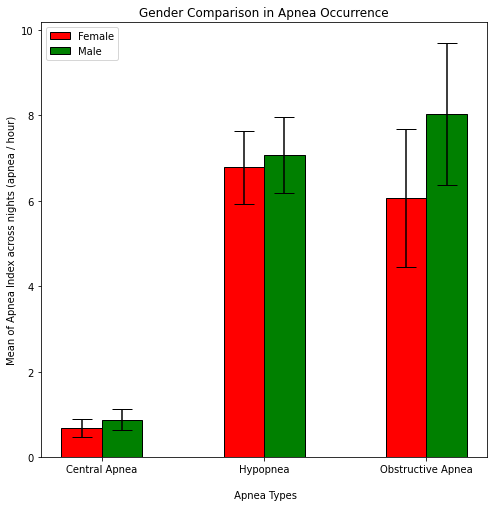

In [23]:
apnea_index = 'apnea index mean'
female = female_flow_stat_apnea_index[apnea_index]
male = male_flow_stat_apnea_index[apnea_index]
 
female_err = female_flow_stat_apnea_index['ci']
male_err = male_flow_stat_apnea_index['ci']
    
n= len(female)
r = np.arange(n)
width = 0.25

index = female_flow_stat_apnea_index.index

plt.figure(figsize=(8,8))

plt.bar(r, female, color = 'r',
        width = width, edgecolor = 'black',
        label='Female',
       yerr=female_err, capsize=10)

plt.bar(r + width, male, color = 'g',
        width = width, edgecolor = 'black',
        label='Male',
       yerr=male_err, capsize=10)
  
plt.xlabel("\n Apnea Types")
plt.ylabel("Mean of Apnea Index across nights (apnea / hour)")
plt.title("Gender Comparison in Apnea Occurrence")
plt.xticks(r + width/2, index)
plt.legend()

plt.show()

Number of apnea events are counted in each apnea types (central apnea, hypopnea and obstructive apnea) in each night and divided by the total sleeping hours in that night.  Mean of apnea index are shown as histograms by apnea types and gender.
Error bars show the confidence interval with 95%. Minimum considered duration is 10 sec

In [24]:
male_flow_data_duration = flow_data_duration.loc[flow_data_duration['gender'] == 'male']
male_flow_data_duration

,duration,type,start,stop,gender,ID,age,BMI,age rank,BMI rank
0,102.0,Obstructive Apnea,2022-05-17 23:03:52.246,2022-05-17 23:05:34.246,male,1,61,25.396568,55-64,25-30
1,10.0,Obstructive Apnea,2022-05-17 23:06:06.246,2022-05-17 23:06:15.996,male,1,61,25.396568,55-64,25-30
2,79.0,Hypopnea,2022-05-17 23:25:55.246,2022-05-17 23:27:14.621,male,1,61,25.396568,55-64,25-30
3,14.0,Obstructive Apnea,2022-05-17 23:45:49.246,2022-05-17 23:46:02.996,male,1,61,25.396568,55-64,25-30
4,22.0,Obstructive Apnea,2022-05-17 23:53:20.246,2022-05-17 23:53:42.121,male,1,61,25.396568,55-64,25-30
...,...,...,...,...,...,...,...,...,...,...
55361,17.0,Hypopnea,2022-05-17 06:10:44.646,2022-05-17 06:11:01.455,male,198,46,47.478276,45-54,35-49
55362,17.0,Hypopnea,2022-05-17 06:12:13.781,2022-05-17 06:12:31.268,male,198,46,47.478276,45-54,35-49
55363,17.0,Hypopnea,2022-05-17 06:12:57.074,2022-05-17 06:13:13.882,male,198,46,47.478276,45-54,35-49
55364,17.0,Hypopnea,2022-05-17 06:14:29.604,2022-05-17 06:14:46.752,male,198,46,47.478276,45-54,35-49


In [25]:
female_flow_data_duration = flow_data_duration.loc[flow_data_duration['gender'] == 'female']
female_flow_data_duration

,duration,type,start,stop,gender,ID,age,BMI,age rank,BMI rank
444,16.0,Hypopnea,2022-05-17 00:02:18.129,2022-05-17 00:02:34.204,female,6,32,25.396568,24-34,25-30
445,11.0,Hypopnea,2022-05-17 01:19:18.246,2022-05-17 01:19:29.371,female,6,32,25.396568,24-34,25-30
446,11.0,Hypopnea,2022-05-17 01:20:05.070,2022-05-17 01:20:16.447,female,6,32,25.396568,24-34,25-30
447,16.0,Hypopnea,2022-05-17 01:20:33.512,2022-05-17 01:20:49.341,female,6,32,25.396568,24-34,25-30
448,25.0,Hypopnea,2022-05-17 01:21:16.546,2022-05-17 01:21:41.278,female,6,32,25.396568,24-34,25-30
...,...,...,...,...,...,...,...,...,...,...
79375,15.0,Obstructive Apnea,2022-05-17 03:21:42.414,2022-05-17 03:21:57.694,female,202,55,40.723773,55-64,35-49
79376,23.0,Obstructive Apnea,2022-05-17 03:22:09.246,2022-05-17 03:22:32.621,female,202,55,40.723773,55-64,35-49
79377,20.0,Obstructive Apnea,2022-05-17 03:22:43.246,2022-05-17 03:23:03.121,female,202,55,40.723773,55-64,35-49
79378,21.0,Obstructive Apnea,2022-05-17 03:23:12.246,2022-05-17 03:23:33.246,female,202,55,40.723773,55-64,35-49


In [26]:
drop_list_male = ['Flow Limitation', 'Body event', 'Mixed Apnea', 'Apnea']
drop_list_female = ['Flow Limitation', 'Body event', 'Mixed Apnea', 'Apnea']

In [27]:
male_flow_stat_duration = get_stat_duration(male_flow_data_duration).drop(drop_list_male).sort_index()
male_flow_stat_duration

,count,duration mean,duration std,ci,low duration,high duration
Central Apnea,1700,15.625882,6.027700,0.286539,15.339344,15.912421
Hypopnea,18859,21.222387,9.803957,0.139926,21.082461,21.362313
Obstructive Apnea,22200,23.053378,12.806438,0.168464,22.884914,23.221843


In [28]:
female_flow_stat_duration = get_stat_duration(female_flow_data_duration).drop(drop_list_female).sort_index()
female_flow_stat_duration

,count,duration mean,duration std,ci,low duration,high duration
Central Apnea,1162,15.243546,5.624488,0.323397,14.920149,15.566943
Hypopnea,17077,20.537741,9.276299,0.139131,20.398609,20.676872
Obstructive Apnea,15232,21.120011,12.139497,0.192787,20.927223,21.312798


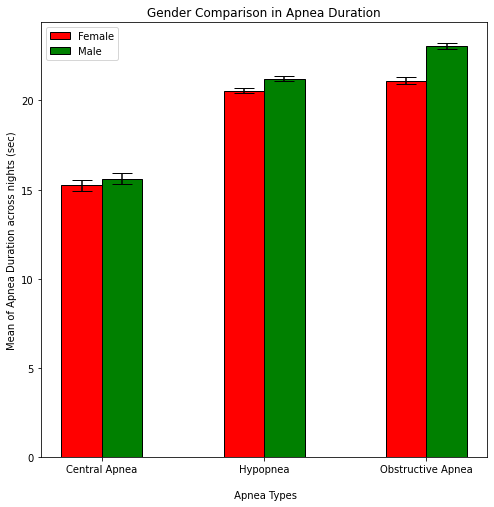

In [29]:
female = female_flow_stat_duration['duration mean']
male = male_flow_stat_duration['duration mean']
 
female_err = female_flow_stat_duration['ci']
male_err = male_flow_stat_duration['ci']
    
n= len(female)
r = np.arange(n)
width = 0.25

index = female_flow_stat_duration.index

plt.figure(figsize=(8,8))

plt.bar(r, female, color = 'r',
        width = width, edgecolor = 'black',
        label='Female',
       yerr=female_err, capsize=10)
plt.bar(r + width, male, color = 'g',
        width = width, edgecolor = 'black',
        label='Male',
       yerr=male_err, capsize=10)
  
plt.xlabel("\n Apnea Types")
plt.ylabel("Mean of Apnea Duration across nights (sec)")
plt.title("Gender Comparison in Apnea Duration")
plt.xticks(r + width/2, index)
plt.legend()

plt.show()

Duration of apnea events are computed in eaach apnea types (central apnea, hypopnea and obstructive apnea) in each night. Mean of apnea durations are shown as histograms by apnea types and gender.
Error bars show the confidence interval with 95%. Minimum considered duration is 10 sec

In [32]:
male_flow_data_duration_age = get_stat_age_duration(male_flow_data_duration).sort_index()
male_flow_data_duration_age

,count,duration mean,duration std,ci,low duration,high duration
24-34,28075,21.873660,11.428753,0.133689,21.739971,22.007349
35-44,4257,17.360817,7.677869,0.230645,17.130172,17.591463
45-54,3695,20.527470,10.364643,0.334197,20.193272,20.861667
55-64,6628,28.879451,14.952168,0.359972,28.519479,29.239423
≥65,2095,24.717422,10.713173,0.458756,24.258666,25.176179


In [33]:
female_flow_data_duration_age = get_stat_age_duration(female_flow_data_duration).sort_index()
female_flow_data_duration_age

,count,duration mean,duration std,ci,low duration,high duration
24-34,1071,17.666667,9.521348,0.570243,17.096424,18.236909
35-44,243,21.547325,9.854773,1.239081,20.308244,22.786406
45-54,7579,18.077979,8.846458,0.199168,17.878811,18.277147
55-64,25103,22.159622,11.745565,0.145301,22.014322,22.304923
≥65,634,17.441640,6.882487,0.535743,16.905897,17.977384


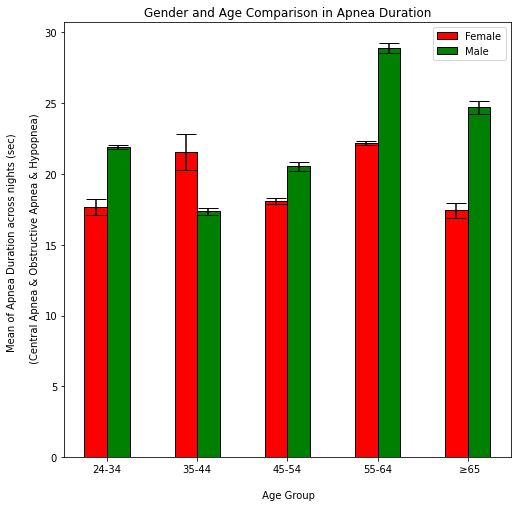

In [34]:
female = female_flow_data_duration_age['duration mean']
male = male_flow_data_duration_age['duration mean']
 
female_err = female_flow_data_duration_age['ci']
male_err = male_flow_data_duration_age['ci']
    
n= len(female)
r = np.arange(n)
width = 0.25

index = female_flow_data_duration_age.index

plt.figure(figsize=(8,8))

plt.bar(r, female, color = 'r',
        width = width, edgecolor = 'black',
        label='Female',
       yerr=female_err, capsize=10)
plt.bar(r + width, male, color = 'g',
        width = width, edgecolor = 'black',
        label='Male',
       yerr=male_err, capsize=10)
  
plt.xlabel("\n Age Group")
plt.ylabel("Mean of Apnea Duration across nights (sec) \n \n (Central Apnea & Obstructive Apnea & Hypopnea)")
plt.title("Gender and Age Comparison in Apnea Duration")
plt.xticks(r + width/2, index)
plt.legend()

plt.show()

Duration of apnea events are computed in all apnea types (combination of central apnea, hypopnea and obstructive apnea) in each night.
Mean of apnea durations are shown as histograms by gender and by age group.
Error bars show the confidence interval with 95%. Minimum considered duration is 10 sec

In [35]:
male_flow_stat_index_age = get_stat_age_index(male_flow_data_apnea_index).sort_index()
male_flow_stat_index_age

,count,apnea index mean,apnea index std,ci,low apnea index,high apnea index
24-34,403,5.247729,8.301733,0.810536,4.437193,6.058265
35-44,73,5.972303,13.125373,3.010969,2.961334,8.983272
45-54,74,4.352696,6.579833,1.499184,2.853512,5.851880
55-64,67,7.954632,10.761430,2.576847,5.377785,10.531479
≥65,17,8.327872,8.188149,3.892399,4.435473,12.220271


In [36]:
female_flow_stat_index_age = get_stat_age_index(female_flow_data_apnea_index).sort_index()
female_flow_stat_index_age

,count,apnea index mean,apnea index std,ci,low apnea index,high apnea index
24-34,45,1.819323,1.985665,0.580171,1.239152,2.399493
35-44,9,2.673776,3.723562,2.432727,0.241049,5.106504
45-54,134,4.616574,10.289778,1.742247,2.874327,6.358821
55-64,366,5.293667,8.099183,0.829768,4.463899,6.123435
≥65,9,4.270940,3.286875,2.147425,2.123515,6.418365


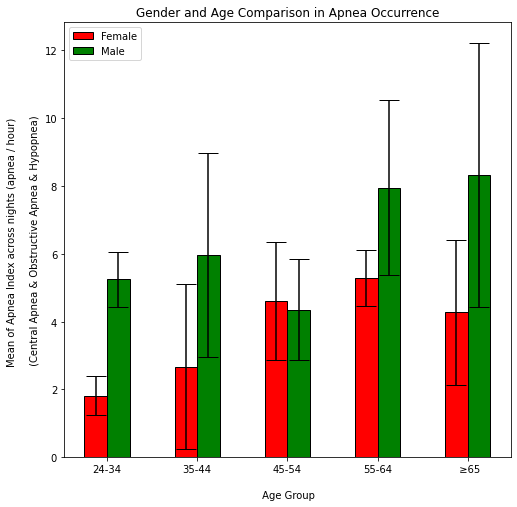

In [37]:
apnea_index = 'apnea index mean'
female = female_flow_stat_index_age[apnea_index]
male = male_flow_stat_index_age[apnea_index]
 
female_err = female_flow_stat_index_age['ci']
male_err = male_flow_stat_index_age['ci']
    
n= len(female)
r = np.arange(n)
width = 0.25

index = female_flow_stat_index_age.index

plt.figure(figsize=(8,8))

plt.bar(r, female, color = 'r',
        width = width, edgecolor = 'black',
        label='Female',
       yerr=female_err, capsize=10)

plt.bar(r + width, male, color = 'g',
        width = width, edgecolor = 'black',
        label='Male',
       yerr=male_err, capsize=10)
  
plt.xlabel("\n Age Group")
plt.ylabel("Mean of Apnea Index across nights (apnea / hour) \n \n (Central Apnea & Obstructive Apnea & Hypopnea) ")
plt.title("Gender and Age Comparison in Apnea Occurrence")
plt.xticks(r + width/2, index)
plt.legend()

plt.show()

Number of apnea events are counted in all apnea types (combination of central apnea, hypopnea and obstructive apnea) in each night and divided by the total sleeping hours in that night.  Mean of apnea index are shown as histograms by gender and age group.
Error bars show the confidence interval with 95%. Minimum considered duration is 10 sec

In [39]:
male_flow_stat_apnea_index_bmi = get_stat_bmi_index(male_flow_data_apnea_index)
male_flow_stat_apnea_index_bmi

,count,apnea index mean,apnea index std,ci,low apnea index,high apnea index
18-25,45,4.915794,6.451777,1.885077,3.030717,6.800871
25-30,112,4.414972,6.250280,1.157568,3.257404,5.572540
30-35,71,8.442718,15.697689,3.651427,4.791291,12.094145
35-49,406,5.498340,8.386585,0.815790,4.682550,6.314130


In [40]:
female_flow_stat_apnea_index_bmi = get_stat_bmi_index(female_flow_data_apnea_index)
female_flow_stat_apnea_index_bmi

,count,apnea index mean,apnea index std,ci,low apnea index,high apnea index
18-25,125,3.684244,9.664541,1.694269,1.989975,5.378512
25-30,44,2.649905,3.124881,0.923343,1.726561,3.573248
30-35,12,2.986437,3.779868,2.138662,0.847776,5.125099
35-49,382,5.464690,8.293503,0.831692,4.632998,6.296382


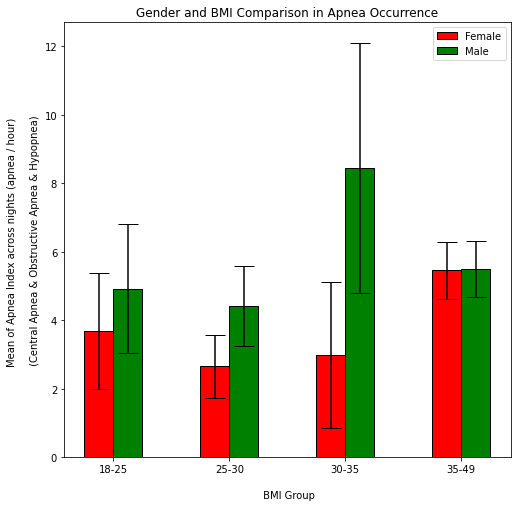

In [41]:
apnea_index = 'apnea index mean'
female = female_flow_stat_apnea_index_bmi[apnea_index]
male = male_flow_stat_apnea_index_bmi[apnea_index]
 
female_err = female_flow_stat_apnea_index_bmi['ci']
male_err = male_flow_stat_apnea_index_bmi['ci']
    
n= len(female)
r = np.arange(n)
width = 0.25

index = female_flow_stat_apnea_index_bmi.index

plt.figure(figsize=(8,8))

plt.bar(r, female, color = 'r',
        width = width, edgecolor = 'black',
        label='Female',
       yerr=female_err, capsize=10)

plt.bar(r + width, male, color = 'g',
        width = width, edgecolor = 'black',
        label='Male',
       yerr=male_err, capsize=10)
  
plt.xlabel("\n BMI Group")
plt.ylabel("Mean of Apnea Index across nights (apnea / hour) \n \n (Central Apnea & Obstructive Apnea & Hypopnea) ")
plt.title("Gender and BMI Comparison in Apnea Occurrence")
plt.xticks(r + width/2, index)
plt.legend()

plt.show()

Number of apnea events are counted in all apnea types (combination of central apnea, hypopnea and obstructive apnea) in each night and divided by the total sleeping hours in that night.  Mean of apnea index are shown as histograms by gender and BMI group.
Error bars show the confidence interval with 95%. Minimum considered duration is 10 sec

In [43]:
male_flow_stat_apnea_duration_bmi = get_stat_bmi_duration(male_flow_data_duration)
male_flow_stat_apnea_duration_bmi

,count,duration mean,duration std,ci,low duration,high duration
18-25,2224,26.338129,13.848446,0.575559,25.762571,26.913688
25-30,5471,20.389691,10.282101,0.272461,20.117230,20.662152
30-35,7029,24.444587,14.112412,0.329921,24.114665,24.774508
35-49,30026,22.150936,11.488314,0.129946,22.020990,22.280882


In [44]:
female_flow_stat_apnea_duration_bmi = get_stat_bmi_duration(female_flow_data_duration)
female_flow_stat_apnea_duration_bmi

,count,duration mean,duration std,ci,low duration,high duration
18-25,5101,19.331308,9.971568,0.273648,19.057660,19.604955
25-30,1350,20.431852,10.914698,0.582239,19.849613,21.014090
30-35,411,18.177616,8.690903,0.840234,17.337382,19.017849
35-49,27768,21.421708,11.391797,0.133991,21.287717,21.555700


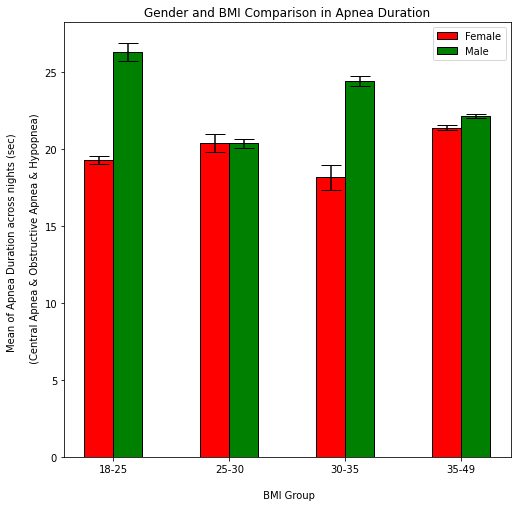

In [45]:
female = female_flow_stat_apnea_duration_bmi['duration mean']
male = male_flow_stat_apnea_duration_bmi['duration mean']
 
female_err = female_flow_stat_apnea_duration_bmi['ci']
male_err = male_flow_stat_apnea_duration_bmi['ci']
    
n= len(female)
r = np.arange(n)
width = 0.25

index = female_flow_stat_apnea_duration_bmi.index

plt.figure(figsize=(8,8))

plt.bar(r, female, color = 'r',
        width = width, edgecolor = 'black',
        label='Female',
       yerr=female_err, capsize=10)
plt.bar(r + width, male, color = 'g',
        width = width, edgecolor = 'black',
        label='Male',
       yerr=male_err, capsize=10)
  
plt.xlabel("\n BMI Group")
plt.ylabel("Mean of Apnea Duration across nights (sec) \n \n (Central Apnea & Obstructive Apnea & Hypopnea)")
plt.title("Gender and BMI Comparison in Apnea Duration")
plt.xticks(r + width/2, index)
plt.legend()

plt.show()

Duration of apnea events are computed in all apnea types (combination of central apnea, hypopnea and obstructive apnea) in each night.
Mean of apnea durations are shown as histograms by gender and by BMI group.
Error bars show the confidence interval with 95%. Minimum considered duration is 10 sec

In [46]:
age_df = pd.DataFrame(id_to_age.items(), columns=['ID', 'Age'])
age_df['age group'] = pd.cut(age_df.Age, bins=[24,34,44,54,64,72], labels=['24-34', '35-44', '45-54', '55-64',' ≥65'])
age_distribution = age_df.groupby('age group').count().rename(columns = {'ID':'number of patients'}).drop('Age', 1)
age_distribution

<ipython-input-46-88d806b93e4b>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  age_distribution = age_df.groupby('age group').count().rename(columns = {'ID':'number of patients'}).drop('Age', 1)


,number of patients
age group,
24-34,29
35-44,19
45-54,24
55-64,23
≥65,7


In [47]:
bmi_df = pd.DataFrame(id_to_bmi.items(), columns=['ID', 'BMI'])
bmi_df['BMI group'] = pd.cut(bmi_df.BMI, bins=[18,25,30,35,49], labels=['18-25', '25-30', '30-35','35-49'])
bmi_distribution = bmi_df.groupby('BMI group').count().rename(columns = {'ID':'number of patients'}).drop('BMI', 1)
bmi_distribution

<ipython-input-47-41119f6b773c>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  bmi_distribution = bmi_df.groupby('BMI group').count().rename(columns = {'ID':'number of patients'}).drop('BMI', 1)


,number of patients
BMI group,
18-25,20
25-30,33
30-35,18
35-49,31
